# Implementing a Recommender System using LightGCN

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import sample_mini_batch
from lightGCN import LightGCN

import torch
from torch import optim

from torch_sparse import SparseTensor

In [2]:
# Lets start by loading the data
data = torch.load("data/hetero_data_no_coauthor.pt", weights_only=False)

# We only need the edges for light GCN
edge_index = data["author", "writes", "paper"].edge_index
author_ids = data["author"].node_id
paper_ids = data["paper"].node_id

print(f"Number of authors: {len(author_ids)}")
print(f"Number of papers: {len(paper_ids)}")
print(f"Number of edges: {edge_index.shape[1]}")

Number of authors: 90941
Number of papers: 63854
Number of edges: 320187


In [3]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_authors, num_papers = len(author_ids), len(paper_ids)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

# Here we enumearte the edges
# Then we split them into train, val, test sets
train_indices, test_indices = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=1,
)
val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=1,
)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [4]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
# We dont need to do this, but it is more efficient for large graphs

train_sparse_edge_index = SparseTensor(
    row=train_edge_index[0],
    col=train_edge_index[1],
    sparse_sizes=(num_authors + num_papers, num_authors + num_papers),
)
val_sparse_edge_index = SparseTensor(
    row=val_edge_index[0],
    col=val_edge_index[1],
    sparse_sizes=(num_authors + num_papers, num_authors + num_papers),
)
test_sparse_edge_index = SparseTensor(
    row=test_edge_index[0],
    col=test_edge_index[1],
    sparse_sizes=(num_authors + num_papers, num_authors + num_papers),
)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample



In [5]:
def bpr_loss(
    users_emb_final,
    pos_items_emb_final,
    neg_items_emb_final,
):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        pos_items_emb_final (torch.Tensor): positive e_i_k
        neg_items_emb_final (torch.Tensor): negative e_i_k
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1)  # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1)  # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))

    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [6]:
# helper function to get N_u
def get_author_positive_papers(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    author_pos_papers = {}
    for i in range(edge_index.shape[1]):
        author = edge_index[0][i].item()
        paper = edge_index[1][i].item()
        if author not in author_pos_papers:
            author_pos_papers[author] = []
        author_pos_papers[author].append(paper)
    return author_pos_papers


# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(
        r, dim=-1
    )  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor(
        [len(groundTruth[i]) for i in range(len(groundTruth))]
    )
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()


# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1.0 / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1.0 / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.0] = 1.0
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.0
    return torch.mean(ndcg).item()


def get_metrics(
    model, edge_index, exclude_edge_indices, k, batch_size=1024, device=None
):
    if device is None:
        device = next(model.parameters()).device

    user_embedding = model.authors_emb.weight.to(device)
    item_embedding = model.papers_emb.weight.to(device)

    users = edge_index[0].unique()
    test_user_pos_items = get_author_positive_papers(edge_index)

    # Precompute “seen” items (train/val/test) per user to mask
    exclude_dicts = [get_author_positive_papers(ei) for ei in exclude_edge_indices]

    r_all = []
    for start in range(0, users.numel(), batch_size):
        batch_users = users[start : start + batch_size]
        u_ids = batch_users.tolist()
        u_emb = user_embedding[batch_users].to(device)  # [B, d]

        rating = torch.matmul(u_emb, item_embedding.T)  # [B, num_items]

        # mask excluded items for each user in this batch
        for row, u in enumerate(u_ids):
            seen_items = set()
            for d in exclude_dicts:
                seen_items.update(d.get(u, []))
            if seen_items:
                rating[row, list(seen_items)] = -(1 << 10)

        _, top_K_items = torch.topk(rating, k=k, dim=1)  # [B, k]

        # build r for this batch
        for row, u in enumerate(u_ids):
            ground_truth_items = test_user_pos_items[u]
            label = [int(i in ground_truth_items) for i in top_K_items[row].tolist()]
            r_all.append(label)

    r = torch.tensor(r_all, dtype=torch.float32)
    test_user_pos_items_list = [test_user_pos_items[u.item()] for u in users]

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)
    return recall, precision, ndcg


# wrapper function to evaluate model
def evaluation(
    model,
    edge_index,
    sparse_edge_index,
    exclude_edge_indices,
    k,
):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    (
        users_emb_final,
        items_emb_final,
    ) = model.forward(sparse_edge_index)

    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        edge_index,
        batch_size=128,
    )
    users_emb_final = users_emb_final[user_indices]
    pos_items_emb_final = items_emb_final[pos_item_indices]
    neg_items_emb_final = items_emb_final[neg_item_indices]

    loss = bpr_loss(
        users_emb_final,
        pos_items_emb_final,
        neg_items_emb_final,
    ).item()

    recall, precision, ndcg = get_metrics(model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [7]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20

In [8]:
# setup
model = LightGCN(
    num_authors=num_authors,
    num_papers=num_papers,
    embedding_dim=64,
    K=6,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [ ]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    authors_emb_final, papers_emb_final = model.forward(train_sparse_edge_index)

    # mini batching
    (
        batched_author_indices,
        batched_pos_paper_indices,
        batched_neg_paper_indices,
    ) = sample_mini_batch(
        train_edge_index,
        BATCH_SIZE,
    )

    batched_author_indices = batched_author_indices.to(device)
    batched_pos_paper_indices = batched_pos_paper_indices.to(device)
    batched_neg_paper_indices = batched_neg_paper_indices.to(device)

    authors_emb_final = authors_emb_final[batched_author_indices]
    pos_items_emb_final = papers_emb_final[batched_pos_paper_indices]
    neg_items_emb_final = papers_emb_final[batched_neg_paper_indices]

    # loss computation
    train_loss = bpr_loss(
        authors_emb_final,
        pos_items_emb_final,
        neg_items_emb_final,
    )

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model,
            val_edge_index,
            val_sparse_edge_index,
            [train_edge_index],
            K,
        )
        print(
            f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}"
        )
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.6931, val_loss: -0.6932, val_recall@20: 0.0004, val_precision@20: 4e-05, val_ndcg@20: 0.00015


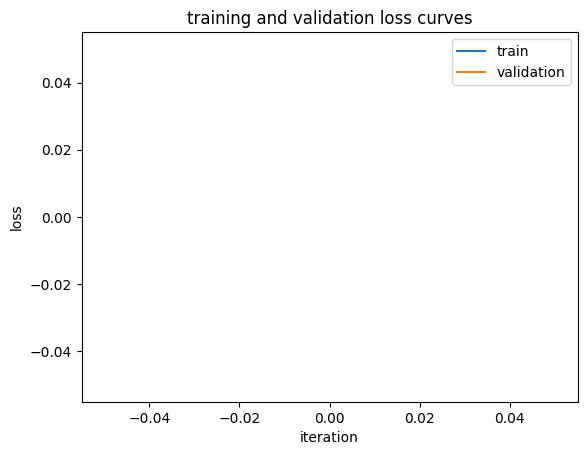

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [ ]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
    model,
    test_edge_index,
    test_sparse_edge_index,
    [train_edge_index, val_edge_index],
    K,
    LAMBDA,
)

print(
    f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}"
)